In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import os
import gc

from shared.utils import *
from shared.local_path import *

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Data Preprocessing
## Audio Data

In [2]:
# label = []
# filepath = []
#
# for classes in os.listdir(AUDIO_PATH):
#     for file in os.listdir(os.path.join(AUDIO_PATH, classes)):
#         file_path = os.path.join(AUDIO_PATH, classes, file)
#
#         filepath.append(file_path)
#         label.append(classes)
#
# audio = pd.DataFrame({
#     'filepath': filepath,
#     'label': label,
# })
#
# del filepath, label
#
# audio.head()

In [3]:
# le = LabelEncoder()
# le.fit(audio['label'])
# audio['label_encoded'] = le.transform(audio['label'])
# num_classes = len(le.classes_)

In [4]:
# with tf.device('/GPU:0'):
#     audio['data'] = audio.filepath.apply(preprocess_audio)
#     audio = audio.sample(frac=1).reset_index(drop=True)

In [5]:
# x_audio = np.stack(audio['data'].values)
# y_audio = audio['label_encoded'].values
# print(x_audio.shape)
# del audio

In [6]:
# x_audio_train, x_temp, y_audio_train, y_temp = train_test_split(
#     x_audio, y_audio, test_size=0.3, random_state=100,
# )
#
# x_audio_val, x_audio_test, y_audio_val, y_audio_test = train_test_split(
#     x_temp, y_temp, test_size=0.5, random_state=222,
# )
#
# del x_audio, y_audio
# print(x_audio_train.shape)
# print(x_audio_train.shape[0] == len(y_audio_train))

## Image Data

In [7]:
filepath = []
label = []

i = 0
for classes in os.listdir(TRAIN_IMAGE_PATH):
    for file in os.listdir(os.path.join(TRAIN_IMAGE_PATH, classes)):
        path = os.path.join(TRAIN_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

train_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(train_df.shape)
print(train_df['label'].unique())
train_df.head()

(33228, 2)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


,filepath,label
0,E:\\Skripsi\data\new_data\train\angry\angry_0_...,angry
1,E:\\Skripsi\data\new_data\train\angry\angry_0_...,angry
2,E:\\Skripsi\data\new_data\train\angry\angry_0_...,angry
3,E:\\Skripsi\data\new_data\train\angry\angry_0_...,angry
4,E:\\Skripsi\data\new_data\train\angry\angry_0_...,angry


In [8]:
filepath = []
label = []

i = 0
for classes in os.listdir(TEST_IMAGE_PATH):
    for file in os.listdir(os.path.join(TEST_IMAGE_PATH, classes)):
        path = os.path.join(TEST_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

img_test_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(img_test_df.shape)
print(img_test_df['label'].unique())
img_test_df.head()

(7311, 2)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


,filepath,label
0,E:\\Skripsi\data\new_data\test\angry\Anger.jpg,angry
1,E:\\Skripsi\data\new_data\test\angry\Anger_1.jpg,angry
2,E:\\Skripsi\data\new_data\test\angry\Anger_10.jpg,angry
3,E:\\Skripsi\data\new_data\test\angry\Anger_11.jpg,angry
4,E:\\Skripsi\data\new_data\test\angry\Anger_12.jpg,angry


In [9]:
le = LabelEncoder()
le.fit(train_df['label'])
train_df['label_encoded'] = le.transform(train_df['label'])
img_test_df['label_encoded'] = le.transform(img_test_df['label'])

In [10]:
with tf.device('/GPU:0'):
    train_df['data'] = train_df['filepath'].apply(lambda x: preprocess_image(x, (100, 100)))
    img_test_df['data'] = img_test_df['filepath'].apply(lambda x: preprocess_image(x, (100, 100)))

train_df.shape

(33228, 4)

In [11]:
x_img = np.stack(train_df['data'].values)
y_img = train_df['label_encoded'].values

x_img_test = np.stack(img_test_df['data'].values)
y_img_test = img_test_df['label_encoded'].values

del train_df, img_test_df

x_img_train, x_img_val, y_img_train, y_img_val = train_test_split(x_img, y_img, test_size=0.3, random_state=100, shuffle=True, stratify=y_img)
del x_img, y_img

# Modeling
## Model Image

In [12]:
base_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top=False,
    input_tensor=tf.keras.layers.Input(shape=(100, 100, 3)),
)

for layer in base_model.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 5s 0us/step


In [13]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [14]:
plot_model(model, show_shapes=True)

In [15]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    # start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('model', 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.2,
                                                    min_lr=1e-6,
                                                    patience=3,
                                                    mode='min'
                                                    )

In [16]:
history = model.fit(
    x_img_train,
    y_img_train,
    validation_data=(x_img_val, y_img_val),
    # callbacks=[early, checkpoint, lr_scheduler],
    epochs=50,
    verbose=2,
    batch_size=64,
    steps_per_epoch=len(x_img_train) // 64,
    validation_steps=len(x_img_val) // 64,
)


Epoch 1/50
363/363 - 74s - loss: 2.4003 - accuracy: 0.1466 - val_loss: 1.9417 - val_accuracy: 0.1754 - 74s/epoch - 205ms/step
Epoch 2/50
363/363 - 68s - loss: 1.9441 - accuracy: 0.1485 - val_loss: 1.9355 - val_accuracy: 0.1558 - 68s/epoch - 186ms/step
Epoch 3/50
363/363 - 65s - loss: 1.9311 - accuracy: 0.1769 - val_loss: 1.9266 - val_accuracy: 0.1816 - 65s/epoch - 180ms/step
Epoch 4/50
363/363 - 65s - loss: 1.9407 - accuracy: 0.1539 - val_loss: 1.9455 - val_accuracy: 0.1495 - 65s/epoch - 180ms/step
Epoch 5/50
363/363 - 65s - loss: 1.9458 - accuracy: 0.1455 - val_loss: 1.9457 - val_accuracy: 0.1495 - 65s/epoch - 178ms/step
Epoch 6/50
363/363 - 64s - loss: 1.9459 - accuracy: 0.1486 - val_loss: 1.9457 - val_accuracy: 0.1495 - 64s/epoch - 177ms/step
Epoch 7/50
363/363 - 64s - loss: 1.9459 - accuracy: 0.1475 - val_loss: 1.9456 - val_accuracy: 0.1495 - 64s/epoch - 178ms/step
Epoch 8/50
363/363 - 65s - loss: 1.9457 - accuracy: 0.1503 - val_loss: 1.9457 - val_accuracy: 0.1495 - 65s/epoch - 179

KeyboardInterrupt: 

# Evaluate Model
## Using the model.evaluate
### using test set

In [17]:
print(model.evaluate(x_img_test, y_img_test, batch_size=BATCH_SIZE, steps=len(x_img_test) // BATCH_SIZE))

228/228 [==============================] - 3s 12ms/step - loss: 3.0614 - accuracy: 0.5916
[3.06137752532959, 0.5915570259094238]


### Using validation set

In [18]:
print(model.evaluate(x_img_val, y_img_val, batch_size=BATCH_SIZE, steps=len(x_img_val) // BATCH_SIZE))

311/311 [==============================] - 4s 12ms/step - loss: 2.7322 - accuracy: 0.6297
[2.73222279548645, 0.6297226548194885]


In [19]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [20]:
plot_and_save('loss', history, 'Loss', 'loss_plot.png')
plot_and_save('accuracy', history, 'Image Classification Accuracy', 'image_class_accuracy_plot.png')

In [21]:
predictions = model.predict(x_img_test)
predictions = np.argmax(predictions, axis=1)

229/229 [==============================] - 3s 11ms/step


In [22]:
classes = [x for x in os.listdir(TRAIN_IMAGE_PATH)]
print(classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


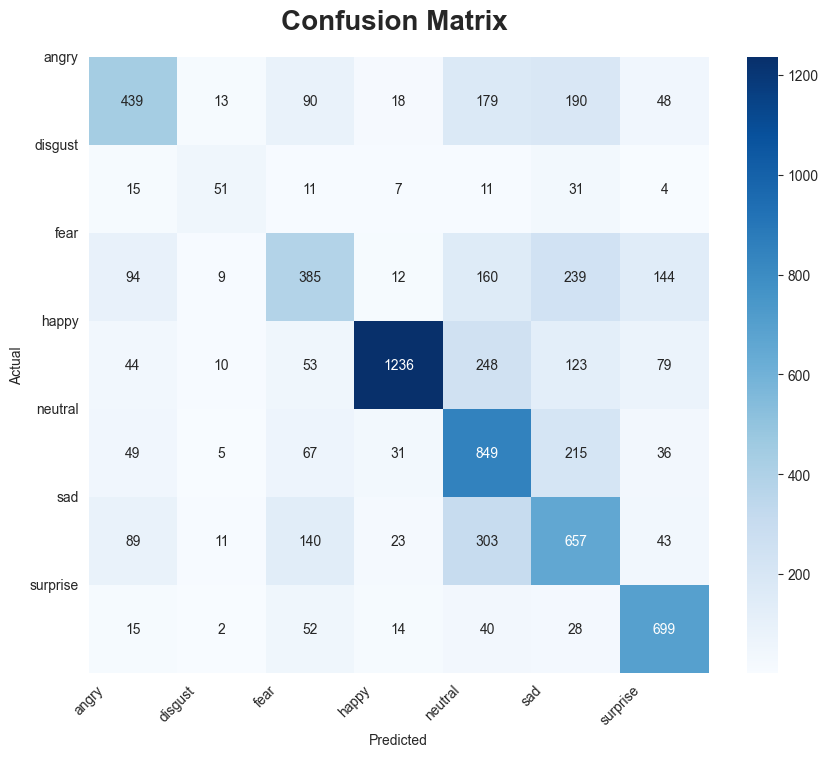

In [23]:
cm = confusion_matrix(y_img_test, predictions)

plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix ', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Set ticks for the x and y axes using class names
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=range(len(classes)), labels=classes, rotation=0)
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
print(classification_report(predictions, y_img_test))

              precision    recall  f1-score   support

           0       0.45      0.59      0.51       745
           1       0.39      0.50      0.44       101
           2       0.37      0.48      0.42       798
           3       0.69      0.92      0.79      1341
           4       0.68      0.47      0.56      1790
           5       0.52      0.44      0.48      1483
           6       0.82      0.66      0.73      1053

    accuracy                           0.59      7311
   macro avg       0.56      0.58      0.56      7311
weighted avg       0.61      0.59      0.59      7311

